### Creating a linear probe to test models domain understanding

#### Preprocessing test-datasets

In [26]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds_domain = load_dataset("AbrehamT/tagged_articles")
# ds = load_dataset("AbrehamT/classified_papers")

# ds_not_domain = load_dataset("mteb/tweet_sentiment_extraction")
ds_not_domain = load_dataset("qiaojin/PubMedQA", "pqa_unlabeled")


In [20]:
# Return True only if the entry has cardiovascular terms but no Alzheimer's terms
def is_cardiovascular_entry(mesh_list):
    has_cardio = any(term in cardio_mesh_terms for term in mesh_list)
    has_alzheimers = any(term in alzheimers_mesh_terms for term in mesh_list)
    return has_cardio and not has_alzheimers

# If any mesh in mesh_list is in alzheimers_mesh_terms, return True
def is_alzheimers_entry(mesh_list):
    return any(term in alzheimers_mesh_terms for term in mesh_list)

# Sentences about cardiovascular diseases (excluding those that also mention Alzheimer's)
ds_not_domain_filtered_neg = ["".join(ex['context']['contexts'][:]) for ex in ds_not_domain['train'] if is_cardiovascular_entry(ex['context']['meshes'])]

# Sentences about Alzheimer's disease
ds_not_domain_filtered_pos = ["".join(ex['context']['contexts'][:]) for ex in ds_not_domain['train'] if is_alzheimers_entry(ex['context']['meshes'])]

print(len(ds_not_domain_filtered_neg), len(ds_not_domain_filtered_pos))


4691 781


In [27]:
cardio_mesh_terms = {
    "Cardiovascular Diseases", "Heart Diseases", "Myocardial Infarction",
    "Coronary Disease", "Atrial Fibrillation", "Heart Failure",
    "Hypertension", "Arrhythmias, Cardiac", "Stroke",
    "Cardiomyopathies", "Valvular Heart Diseases",
    "Statins", "Antihypertensive Agents", "Coronary Artery Bypass", "AlismataceaeApoptosisCell"
}

alzheimers_mesh_terms = {
    "Alzheimer Disease",
    "Alzheimer's Disease",
    "Alzheimer Disease/genetics",
    "Alzheimer Disease/diagnosis",
    "Alzheimer Disease/pathology",
    "Amyloid beta-Peptides",
    "Amyloid beta-Protein Precursor",
    "Amyloid beta-Protein Precursor/genetics",
    "Tau Proteins",
    "tauopathies",
    "Neurofibrillary Tangles",
    "Neurodegenerative Diseases",
    "Dementia",
    "Dementia, Vascular",
    "Mild Cognitive Impairment",
    "Cognition Disorders",
    "Neuroinflammation",
    "Apolipoproteins E",
    "Presenilin-1",
    "Presenilin-2",
    "MAPT",  # tau gene
    "APP",   # amyloid precursor protein
    "PSEN1", "PSEN2"  # presenilin genes
}

# If any mesh in mesh_list is in cardio_mesh_terms, return True
def is_cardiovascular_entry(mesh_list):
    return any(term in cardio_mesh_terms for term in mesh_list)
    # return not any(term in cardio_mesh_terms for term in mesh_list)

# If any mesh in mesh_list is in alzheimers_mesh_terms, return True
def is_alzheimers_entry (mesh_list):
    return any(term in alzheimers_mesh_terms for term in mesh_list)

# Sentences about cardiovascular diseases
ds_not_domain_filtered_neg = ["".join(ex['context']['contexts'][:]) for ex in ds_not_domain['train'] if is_cardiovascular_entry(ex['context']['meshes'])]

# Sentences about Alzheimer's disease
ds_not_domain_filtered_pos = ["".join(ex['context']['contexts'][:]) for ex in ds_not_domain['train'] if is_alzheimers_entry(ex['context']['meshes'])]

print(len(ds_not_domain_filtered_neg), len(ds_not_domain_filtered_pos))


4765 781


In [28]:
import random 

probing_data = []
# positive data
i = 0
for item in ds_not_domain_filtered_pos:
    if i < 781:
        probing_data.append({
            'text': item,
            'label': 1
        })
    i += 1

# negative data
i = 0
for item in ds_not_domain_filtered_neg:
    if i < 1000:
        probing_data.append({
            'text': item,
            'label': 0
        })
    i += 1


random.seed(43)
random.shuffle(probing_data)

In [29]:
from sklearn.model_selection import train_test_split

texts = [item['text'] for item in probing_data]
labels = [item['label'] for item in probing_data]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels
)

# Reconstruct back into dicts
train_data = [{"text": x, "label": y} for x, y in zip(X_train, y_train)]
test_data  = [{"text": x, "label": y} for x, y in zip(X_test, y_test)]


## Loading models

### Utilizing locally trained model (Flan-t5) to generate embeddings

In [30]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5EncoderModel
import torch
import numpy as np

# tokenizer = AutoTokenizer.from_pretrained("AbrehamT/dasc_selfsup")
# encoder = T5EncoderModel.from_pretrained("AbrehamT/dasc_selfsup")

# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
# encoder = T5EncoderModel.from_pretrained("google/flan-t5-xl")

tokenizer = AutoTokenizer.from_pretrained("AbrehamT/adbm-classifier-nounsup")
encoder = T5EncoderModel.from_pretrained("AbrehamT/adbm-classifier-nounsup")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
encoder.eval()

def embed(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation = True, padding = True).to(device)
        with torch.no_grad():
            outputs = encoder(**inputs).last_hidden_state
            emb = outputs.mean(dim=1).squeeze()
            emb = emb.cpu().numpy()
        embeddings.append(emb)
    return np.vstack(embeddings)
# Prepare training data
print('=========Embedding training data (for probe)============')
X_train = embed([ex['text'] for ex in train_data[:]])
y_train = np.array([ex['label'] for ex in train_data[:]])

print('=========Embedding testing data (for probe)============')
X_test = embed([ex['text'] for ex in test_data[:]])
y_test = np.array([ex['label'] for ex in test_data[:]])

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from AbrehamT/adbm-classifier-nounsup led to unexpected keys not found in the model: decoder.block.0.layer.0.SelfAttention.k.lora_A.default.weight, decoder.block.0.layer.0.SelfAttention.k.lora_B.default.weight, decoder.block.0.layer.0.SelfAttention.o.lora_A.default.weight, decoder.block.0.layer.0.SelfAttention.o.lora_B.default.weight, decoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight, decoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight, decoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight, decoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight, decoder.block.0.layer.1.EncDecAttention.k.lora_A.default.weight, decoder.block.0.layer.1.EncDecAttention.k.lora_B.default.weight, decoder.block.0.layer.1.EncDecAttention.o.lora_A.default.weight, decoder.block.0.layer.1.EncDecAttention.o.lora_B.default.weight, decoder.block.0.layer.1.EncDecAttention.q.lora_A.default.weight, decoder.block.0.layer.1.EncDecAttention.q.lora_B.default.weigh

=========Embedding training data (for probe)============
=========Embedding testing data (for probe)============


### Utilizing the Sentence-T5 models instead to generate embeddings

In [13]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5EncoderModel
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/sentence-t5-xl")
encoder = T5EncoderModel.from_pretrained("sentence-transformers/sentence-t5-xl")

# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
# encoder = T5EncoderModel.from_pretrained("google/flan-t5-xl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
encoder.eval()

def embed(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation = True, padding = True).to(device)
        with torch.no_grad():
            outputs = encoder(**inputs).last_hidden_state
            emb = outputs.mean(dim=1).squeeze()
            emb = emb.cpu().numpy()
        embeddings.append(emb)
    return np.vstack(embeddings)
# Prepare training data
print('=========Embedding training data (for probe)============')
X_train = embed([ex['text'] for ex in train_data[:]])
y_train = np.array([ex['label'] for ex in train_data[:]])

print('=========Embedding testing data (for probe)============')
X_test = embed([ex['text'] for ex in test_data[:]])
y_test = np.array([ex['label'] for ex in test_data[:]])


=========Embedding training data (for probe)============
=========Embedding testing data (for probe)============


### Utilizing (BiomedNLP)-BERT to generate embeddings

In [19]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
model = AutoModelForMaskedLM.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def embed(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation = True, padding = True, max_length = 512).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states = True)
            last_state = outputs.hidden_states[-1]
            cls_embedding = last_state[:, 0, :]
        embeddings.append(cls_embedding[0].cpu().detach().numpy())
    return np.vstack(embeddings)

# Prepare training data
print('=========Embedding training data (for probe)============')
X_train = embed([ex['text'] for ex in train_data[:]])
y_train = np.array([ex['label'] for ex in train_data[:]])

print('=========Embedding testing data (for probe)============')
X_test = embed([ex['text'] for ex in test_data[:]])
y_test = np.array([ex['label'] for ex in test_data[:]])

Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


=========Embedding training data (for probe)============
=========Embedding testing data (for probe)============


### Utilizing (cambridgeltl/SapBERT-from-PubMedBERT) to generate embeddings

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext-mean-token")
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext-mean-token")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def embed(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation = True, padding = True, max_length = 512).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states = True)
            last_state = outputs.hidden_states[-1]
            cls_embedding = last_state[:, 0, :]
        embeddings.append(cls_embedding[0].cpu().detach().numpy())
    return np.vstack(embeddings)

# Prepare training data
print('=========Embedding training data (for probe)============')
X_train = embed([ex['text'] for ex in train_data[:]])
y_train = np.array([ex['label'] for ex in train_data[:]])

print('=========Embedding testing data (for probe)============')
X_test = embed([ex['text'] for ex in test_data[:]])
y_test = np.array([ex['label'] for ex in test_data[:]])

## Training & Testing Probe

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9103641456582633
F1 Score: 0.8940397350993378
Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       200
           1       0.93      0.86      0.89       157

    accuracy                           0.91       357
   macro avg       0.91      0.90      0.91       357
weighted avg       0.91      0.91      0.91       357



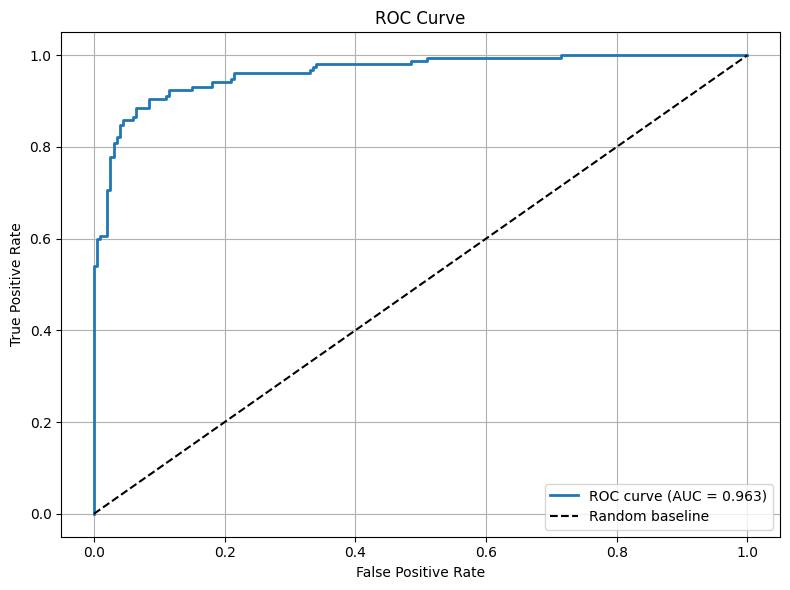

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
probs = clf.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Using t-SNE to visualize embeddings

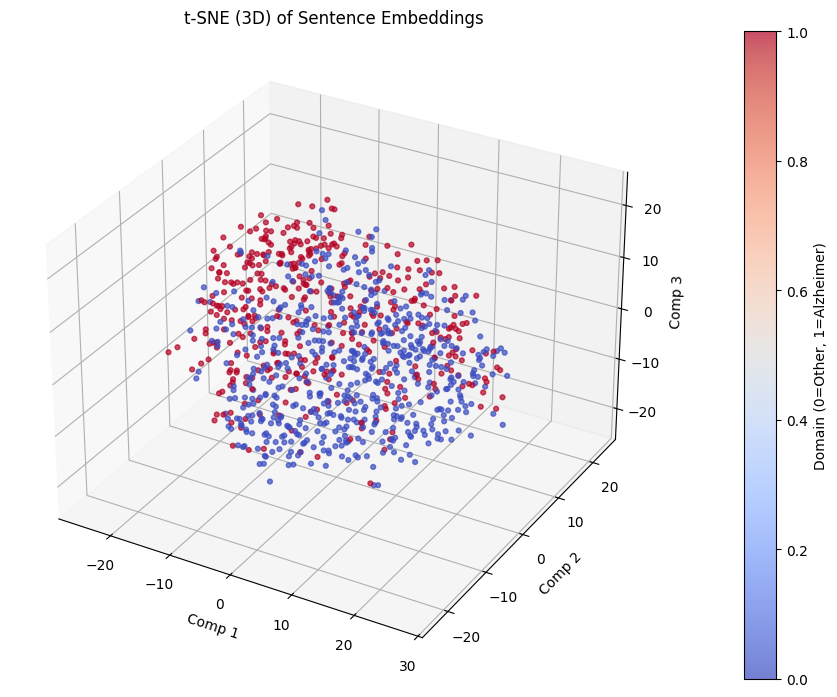

In [54]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# X_train: [N, 2048], y_train: [N]
sample_size = 1000
X_sample = X_train[:sample_size]
y_sample = y_train[:sample_size]

# 2048 -> 50 via PCA (keeps it fast/denoised)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sample)

# 50 -> 3 via t-SNE
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)  # shape: [N, 3]

# 3D plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2],
                c=y_sample, cmap="coolwarm", s=12, alpha=0.7)
ax.set_title("t-SNE (3D) of Sentence Embeddings")
ax.set_xlabel("Comp 1"); ax.set_ylabel("Comp 2"); ax.set_zlabel("Comp 3")
cb = plt.colorbar(sc, ax=ax, pad=0.1, label="Domain (0=Other, 1=Alzheimer)")
plt.tight_layout()
plt.show()


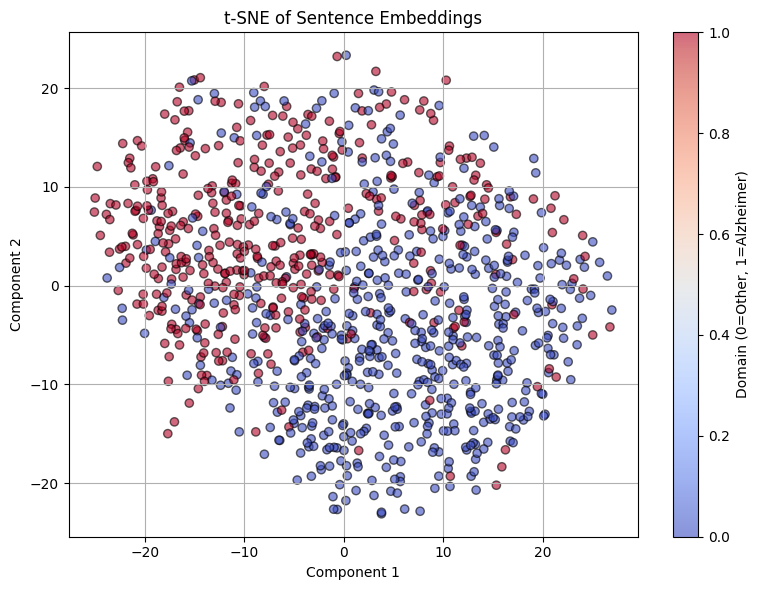

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# X: embeddings (shape: [N, 2048])
# y: labels (shape: [N,])
# Use a smaller sample if you have thousands
sample_size = 1000
X_sample = X_train[:sample_size]
y_sample = y_train[:sample_size]


pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sample)

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_sample, cmap="coolwarm", alpha=0.6, edgecolor="k"
)
plt.title("t-SNE of Sentence Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Domain (0=Other, 1=Alzheimer)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Training logistic regression on X_tsne

In [34]:
from sklearn.linear_model import LogisticRegression

# X_tsne: shape (n_samples, 2)
# y_train_tsne: your labels for each 2D point
clf_tsne = LogisticRegression()
clf_tsne.fit(X_tsne, y_train[:len(X_tsne)])  # Just in case you're using a subset

LogisticRegression()

In [35]:
import numpy as np

x_min, x_max = X_tsne[:, 0].min() - 5, X_tsne[:, 0].max() + 5
y_min, y_max = X_tsne[:, 1].min() - 5, X_tsne[:, 1].max() + 5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

Z = clf_tsne.predict_proba(grid_points)[:, 1]
Z = Z.reshape(xx.shape)


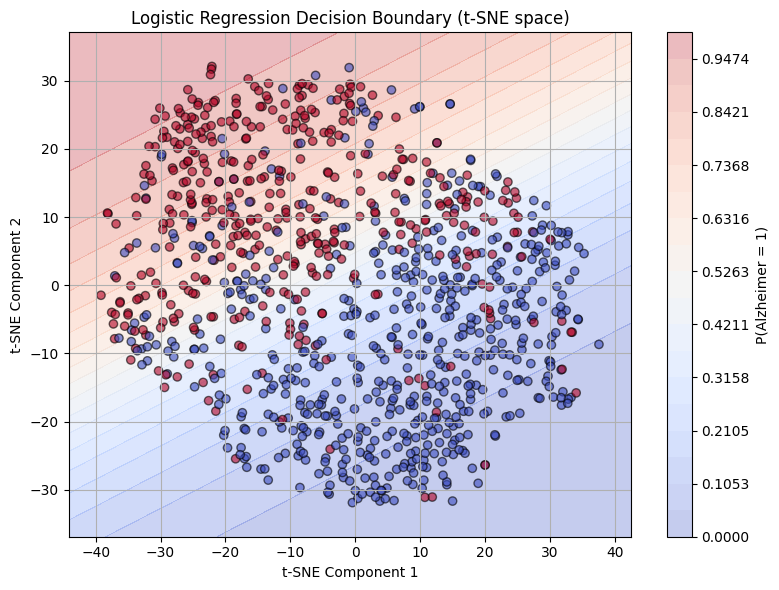

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot decision contour
plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 20), cmap="coolwarm", alpha=0.3)
plt.colorbar(label="P(Alzheimer = 1)")

# Plot actual points
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:len(X_tsne)],
            cmap="coolwarm", edgecolor="k", alpha=0.6)

plt.title("Logistic Regression Decision Boundary (t-SNE space)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### Experimenting with using a small NN for probing tasks

In [37]:
from sklearn.neural_network import MLPClassifier

nn_probe = MLPClassifier(
    hidden_layer_sizes=(128,),     # 1 hidden layer with 128 units
    activation='relu',
    solver='adam',
    alpha=1e-4,                    # L2 penalty (regularization)
    max_iter=200,
    random_state=42
)
nn_probe.fit(X_train, y_train)

y_pred = nn_probe.predict(X_test)


/home/tadesa1/anaconda3/envs/nlp_ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.927170868347339
F1 Score: 0.9161290322580645
Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       200
           1       0.93      0.90      0.92       157

    accuracy                           0.93       357
   macro avg       0.93      0.92      0.93       357
weighted avg       0.93      0.93      0.93       357



In [39]:
from sklearn.neural_network import MLPClassifier

nn_probe = MLPClassifier(hidden_layer_sizes=(64,), activation='relu',
                         solver='adam', max_iter=1000, random_state=42)
nn_probe.fit(X_tsne, y_train[:len(X_tsne)])


MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)

In [40]:
import numpy as np

x_min, x_max = X_tsne[:, 0].min() - 5, X_tsne[:, 0].max() + 5
y_min, y_max = X_tsne[:, 1].min() - 5, X_tsne[:, 1].max() + 5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

Z = clf_tsne.predict_proba(grid_points)[:, 1]
Z = Z.reshape(xx.shape)

Z = nn_probe.predict_proba(grid_points)[:, 1]  # P(class=1)
Z = Z.reshape(xx.shape)


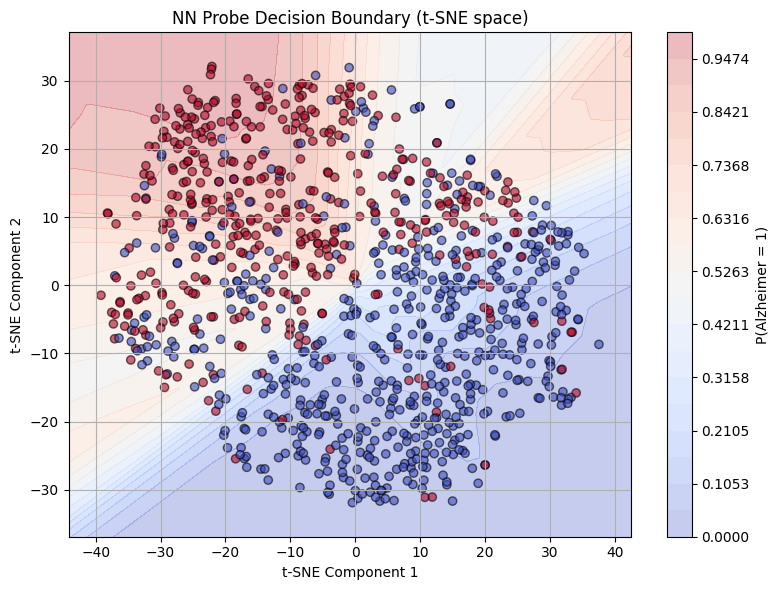

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 20), cmap="coolwarm", alpha=0.3)
plt.colorbar(label="P(Alzheimer = 1)")

# Scatter actual points
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:len(X_tsne)],
            cmap="coolwarm", edgecolor="k", alpha=0.6)

plt.title("NN Probe Decision Boundary (t-SNE space)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
